# Introduction
Hope you're reading this in <font color = 'orange'>Google Colab</font>.

In Part II, we split our data into train/val/ and test. In this Part, we will train our deep learning model to classify tea fermentation levels.

In this Part III, we will:
1. Build a CNN model 
2. Train the model
3. Assess model performance

Looks like a three-step process but it will be more.

## Model building
With reference to the research paper, we will refer to this section frequently:

![TeaNetSection](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/Section35TeaNetLabelled.png)

These are the important bits:
1. Reference architecture (AlexNet)
2. Input image dimensions
3. Summary on the layers
4. Detailed definition of the layers

### Step 1: Import libraries
We'll need quite a few libraries - in no particular order here they are:
1. numpy as np
2. ImageDataGenerator from keras.preprocessing.image
3. Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D from keras.layers
4. BatchNormalization from keras.layers.normalization
5. models, optimizers from keras
6. confusion_matrix from sklearn.metrics

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Step 1: Import libraries
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras import models, optimizers 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Step 2: Implement the original AlexNet first
As mentioned, TeaNet is based on the AlexNet architecture. 

To make your time building TeaNet easier, why not start from AlexNet and then start modifying? 

Very useful resource if you don't know how to create your CNN layers from scratch: https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/

You can even copy the code wholesale first, including comments. You just need the middle portion of the article, and you can stop right after compiling the model.

If you're not sure where to start in the article, start with:
```
AlexNet = models.Sequential()
```
and end at 
```
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])
```

When you get the model summary, make sure the 'Param #' values match and you're all good. 

In [3]:
# Step 2: Implement the original AlexNet
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 96)         384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

### Step 3: Modify AlexNet and turn it into TeaNet
Now that you've successfully implemented AlexNet, time to modify the parameters according to the publication. 

We'll tweak it to ask close as it's needed to TeaNet (plus a bit of our own modification):

<strong>More specifically, to turn AlexNet into TeaNet, you will need to:</strong>
1. Change the input_shape parameter in first layer
2. Change the filter sizes in each layer to match the publication
3. Remove 'padding' parameter in all layers
4. Change the drop out ratio
5. Completely remove the # Output Layer
6. In the 3rd fully connected layer:
    - Change the number of neurons in the third fully connected layer from 1000 to 3
    - Change the activation from 'relu' to 'softmax'
    - Remove the dropout operation
7. Change the compile parameters
    - Change the optimizer from adam to optimizers.SGD with a learning rate of 0.01, and momentum of 0.9
    
At the model summary, see if your parameters look like this:
```
Total params: 239,567
Trainable params: 237,833
Non-trainable params: 1,734
```

You're on the right track.

In [4]:
# Step 3: Modify AlexNet to TeaNet
# Step 2: Implement the original AlexNet
np.random.seed(1000)

#Instantiation
TeaNet = Sequential()

#1st Convolutional Layer
TeaNet.add(Conv2D(filters=32, input_shape=(150,150,3), kernel_size=(11,11), strides=(4,4)))
TeaNet.add(BatchNormalization())
TeaNet.add(Activation('relu'))
TeaNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

#2nd Convolutional Layer
TeaNet.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2)))
TeaNet.add(BatchNormalization())
TeaNet.add(Activation('relu'))
TeaNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#3rd Convolutional Layer
TeaNet.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2)))
TeaNet.add(BatchNormalization())
TeaNet.add(Activation('relu'))


#Passing it to a Fully Connected layer
TeaNet.add(Flatten())
# 1st Fully Connected Layer
TeaNet.add(Dense(512))
TeaNet.add(BatchNormalization())
TeaNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
TeaNet.add(Dropout(0.5))

#2nd Fully Connected Layer
TeaNet.add(Dense(128))
TeaNet.add(BatchNormalization())
TeaNet.add(Activation('relu'))
#Add Dropout
TeaNet.add(Dropout(0.5))

#3rd Fully Connected Layer
TeaNet.add(Dense(3))
TeaNet.add(BatchNormalization())
TeaNet.add(Activation('softmax'))


#Model Summary
TeaNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 35, 35, 32)        11648     
                                                                 
 batch_normalization_9 (Batc  (None, 35, 35, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 35, 35, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 64)        

In [5]:
TeaNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

## Preparing your images
We haven't set our training, validation, and test data yet so we can't train. 

### Step 4: Define the classes
Declare a variable, and assign it with a dictionary with the following key-value pair:
1. 'underfermented tea' - 0
2. 'overfermented tea' - 1
3. 'fermented tea' - 2

The reason why we do this is that sometimes model training on Keras can lead the classes being mixed up. As such, it's better to explicitly declare what our classes and its corresponding values are. 

In [6]:
# Step 4: Declare your classes
TeaClass = {'underfermented tea':0, 'overfermented tea':1, 'fermented tea':2}

### Step 5: Create ImageDataGenerator objects
We will be generating batches of augmented image data during model training, so we will be creating ImageDataGenerator objects. 

Handy reading: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Declare three variables, and assign them ImageDataGenerator objects with the following parameters
1. train generator
    - rescale - 1.0/255
    - shear_range - 0.2
    - zoom_range - 0.2
    - horizontal_flip - True
2. test generator
    - rescale - 1.0/255
3. val generator
    - rescale - 1.0/255

In [7]:
# Step 5: Create your three ImageDataGenerator objects
train_generator=ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_generator=ImageDataGenerator(rescale=1/255)
val_generator=ImageDataGenerator(rescale=1/255)

### Step 6: Declare your train/val/test folder paths
Declare three variables, and assign them the path to your train, val, and test folders. 

Navigate to the folders that you got from Part II Step 6, and copy the path.

In [8]:
# Step 6: Store the path to variables
train_path='/content/drive/MyDrive/Project Tea Fermentation/Black tea fermentation dataset/output/train'
test_path='/content/drive/MyDrive/Project Tea Fermentation/Black tea fermentation dataset/output/test'
val_path='/content/drive/MyDrive/Project Tea Fermentation/Black tea fermentation dataset/output/val'

### Step 7: Declare your train/validation/test .flow_from_directory
Next up, we will declare three new variables, and in each variable you use the .flow_from_directory method from your ImageDataGenerators that you created in Step 5. 

Here are the parameters to use:
1. train set
    - path - the path you declared from Step 6
    - target_size - (150, 150)
    - batch_size - 16
    - class_mode - 'categorical'
    - classes - the dictonary from Step 4
2. test set
    - same as train generator
    - shuffle - False
3. val set
    - same as train generator
    - shuffle - False

If your folder structure is correct, split your files properly, and declare the right paths, you'll see this:

![FlowFromDirectoryResults](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/FlowFromDirectoryOutput.png)

In [9]:
# Step 7: Declare your .flow_from_directory variables
train_generator=train_generator.flow_from_directory(train_path, target_size=(150, 150), batch_size=16, class_mode='categorical', classes=TeaClass)
test_generator=test_generator.flow_from_directory(test_path, target_size=(150, 150), batch_size=16, class_mode='categorical', classes=TeaClass, shuffle=False)
val_generator=val_generator.flow_from_directory(val_path, target_size=(150, 150), batch_size=16, class_mode='categorical', classes=TeaClass, shuffle=False)

Found 4800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## Model training and assessment
### Step 8: Train your CNN
Now that everything is set up, we can now train our model. 

Declare a variable called history, and assign it to your model's .fit() method with the following parameters:
1. train_set - train set from Step 7
2. steps_per_epoch - 20
3. epochs - 20
4. verbose - 1
5. validation_set - val set from Step 7

If everything works, you'll see something like this:

![TrainOutput](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/TrainOutput.png)

Be patient and revisit Steps 2-3 if it doesn't work. You should have
1. low acc_loss
2. low val_loss
3. high acc
4. high val_acc

In [10]:
# Step 8: Train your model
hisotry=TeaNet.fit_generator(train_generator, steps_per_epoch = 20, epochs = 20, verbose=1, validation_data = val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
20/20 [==============================] - 273s 14s/step - loss: 0.7321 - accuracy: 0.7437 - val_loss: 11.2665 - val_accuracy: 0.3333
Epoch 2/20
20/20 [==============================] - 65s 3s/step - loss: 0.2898 - accuracy: 0.9875 - val_loss: 9.3618 - val_accuracy: 0.3333
Epoch 3/20
20/20 [==============================] - 65s 3s/step - loss: 0.2423 - accuracy: 0.9812 - val_loss: 5.3072 - val_accuracy: 0.3333
Epoch 4/20
20/20 [==============================] - 60s 3s/step - loss: 0.1645 - accuracy: 1.0000 - val_loss: 3.5794 - val_accuracy: 0.3333
Epoch 5/20
20/20 [==============================] - 53s 3s/step - loss: 0.1216 - accuracy: 1.0000 - val_loss: 2.1074 - val_accuracy: 0.3333
Epoch 6/20
20/20 [==============================] - 49s 2s/step - loss: 0.1281 - accuracy: 0.9906 - val_loss: 1.1295 - val_accuracy: 0.3333
Epoch 7/20
20/20 [==============================] - 49s 2s/step - loss: 0.1108 - accuracy: 0.9906 - val_loss: 0.9384 - val_accuracy: 0.3333
Epoch 8/20
20/20 

### Step 9: Make predictions using test set
After we're done training, you will notice that both accuracy and validation accuracy is high. How does it fare against the test set? 

Use the .predict method of your CNN model and use the test set variable that you declared in Step 7 to make your predictions.

You should see something like this: 

![TestSetPrediction](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/PredictionFromTestSet.png)

In [12]:
# Step 9: Make predictions using your test set
y_pred=TeaNet.predict(test_generator)
y_pred

array([[0.9792427 , 0.01025292, 0.01050442],
       [0.9781597 , 0.0113948 , 0.01044545],
       [0.9792427 , 0.01025292, 0.01050442],
       ...,
       [0.02547402, 0.02206491, 0.9524611 ],
       [0.02547404, 0.02206493, 0.952461  ],
       [0.01765895, 0.01643343, 0.9659076 ]], dtype=float32)

### Step 10: Get the index of maximum value in each prediction array
If you've noticed, each item in the list of prediction is another list containing the probabilities of each class. 

Use numpy's argmax method to get the index of the highest value in the array - that is your class prediction.

<strong>Hint: Google "How to find the predicted class for a specific testing sample"</strong>

In [14]:
# Step 10: Get the index of the max value in each prediction array
y_pred_cat=np.argmax(y_pred,axis=1)
y_pred_cat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Step 11: Assess your prediction with a confusion matrix
Earlier on, you imported confusion_matrix from sklearn.metrics. 

Now's the time to use it, as you get the .classes attribute from your test set from Step 7, and compare it with the predictions you got from Step 10.

In [22]:
# Step 11: Print a confusion matrix
y_true=test_generator.classes
confusion_matrix(y_true,y_pred_cat)

array([[200,   0,   0],
       [  0, 200,   0],
       [  0,   0, 200]])

### Step 12: Plot your accuracy and loss
Wait a minute - the results from Step 11 seems too good. What's wrong, and are we overfitting?

Judging from the fact that we used a test set that was completely separate from train set and validation set, we can say that our results are great. 

Nonetheless, let's plot graphs:
1. accuracy vs epoch
2. loss vs epoch

And in each graph we compare the changes over time for both train and val over the epochs.

To retrieve the information you need, you can use the .history attribute from the 'history' variable that you declared in Step 8.

![TrainValAccuracyLoss](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectTeaFermentation/TrainValAccuracyLossPlot.png)

You'll see something like this.

<strong>Hint: Google "keras plot training, validation and test set accuracy"</strong>

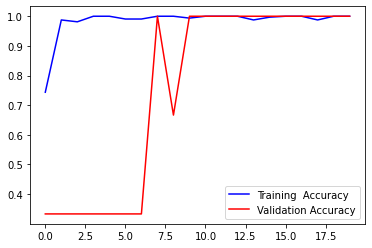

In [27]:
# Step 12: Plot your accuracy and val plots
#Plotting the training accuracy and validation accuracy
plt.plot(hisotry.history['accuracy'],color='b',label='Training  Accuracy')
plt.plot(hisotry.history['val_accuracy'],color='r',label='Validation Accuracy')
plt.legend()
plt.show()

### End of Part III
That was long, wasn't it? But based on the results from Step 11 and Step 12, we would say it's well worth it. 

If you carried everything out well so far, congratulations! 

You're theoretically supposed to train a model that can predict 100% the state of fermentation of the leave based on image data alone. 

If you haven't, it's a good time to go back and revisit steps that you might have executed wrongly. 

Otherwise, let's head on to Parts IV and V where we will take a step back and return to our machine learning roots.